It can be said that Bayes' rule is used to _update_ our belief $P(Z)$ about what the underlying _causal_ variable $Z$ is:

$$
P(X|Z) = \frac{P(X|Z)P(Z)}{P(X)}
$$

We start out with some belief $P(Z)$ about the causal variable $Z$. _Belief_ because we don't know what the next value of $Z$ will be, we just assume some distribution of $Z$. We also have a generative model $P(X|Z)$ that too is not 100% accurate: give some value of $Z$ it (almost) never generates the same value $X$. That is why we use the probability $P(Z)$. 



<img src="./img/bayes.jpg" alt="Drawing" style="width: 700px;"/>



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from termcolor import colored

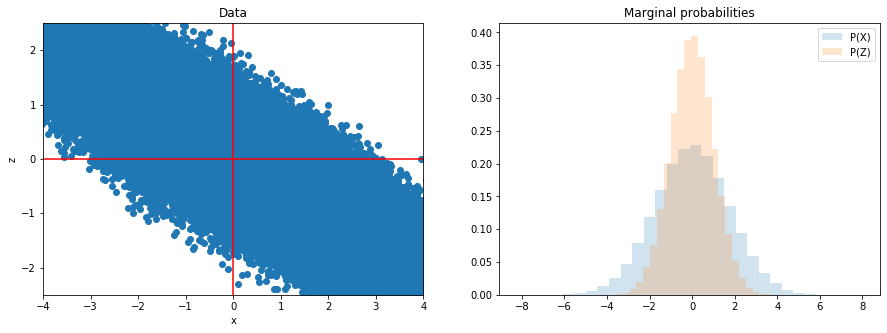

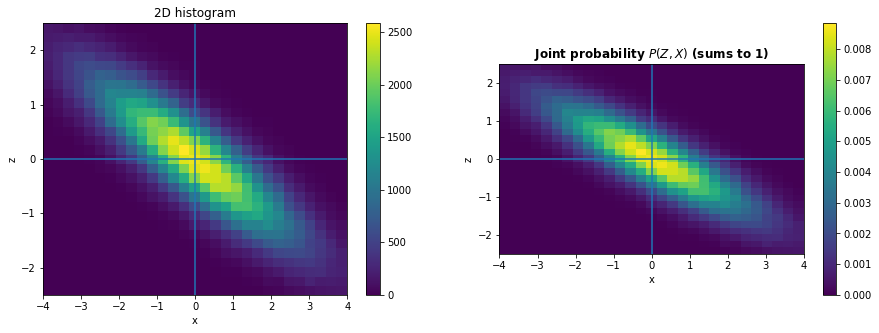

In [6]:
m_x, m_z = 0, 0
var_x, var_z = 3, 1.0
extent = [-4, 4, -2.5, 2.5]
Nx = 29
Nz = 29


mean = (m_x, m_z)
cov = [[var_x, -1.5], [-1.5, var_z]]
x_ = np.linspace(extent[0], extent[1], Nx)
z_ = np.linspace(extent[2], extent[3], Nz)

px = stats.norm.pdf(x_, m_x, cov[0][0])
pz = stats.norm.pdf(z_, m_z, cov[1][1])


x = np.random.multivariate_normal(mean, cov, 300000)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Data')
plt.scatter(x[:,0], x[:,1])
plt.ylim(extent[2], extent[3])
plt.xlim(extent[0], extent[1])
plt.axvline(m_x, color='red')
plt.axhline(m_z, color='red')
plt.xlabel('x')
plt.ylabel('z')

plt.subplot(1,2,2)
plt.title('Marginal probabilities')
plt.hist(x[:,0], bins=30, density=True, alpha=0.2,  label='P(X)')
plt.hist(x[:,1], bins=30, density=True, alpha=0.2, label='P(Z)')
plt.legend()


plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
m = plt.hist2d(x[:,0], x[:,1], 
               bins=(
                   np.linspace(extent[0], extent[1], Nx+1),
                   np.linspace(extent[2], extent[3], Nz+1)))
plt.xlabel('x')
plt.ylabel('z')
plt.axvline(m_x)
plt.axhline(m_z)
plt.title('2D histogram')
plt.colorbar()

Pxz = m[0].T/np.sum(m[0].T)

plt.subplot(1,2,2)
plt.imshow(Pxz, extent=extent, origin='lower')
plt.colorbar()
plt.title('Joint probability $P(Z,X)$ (sums to 1)', weight='bold')
plt.xlabel('x')
plt.ylabel('z')
plt.axvline(m_x)
plt.axhline(m_z)

## to get the conditional probability $P(Z|X)$, you need to take the columns of the matrix P(Z, X) and normalize them so that they sum to 1 (conditional probabilities, like any probability, must sum to 1)

all the P(Z|X) (columns of P(Z,X)) sum to 1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]
all the P(X|Z) (rows of P(Z,X)) sum to 1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


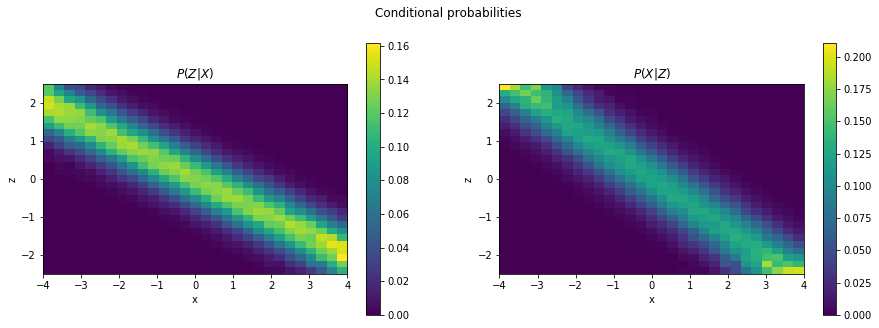

In [7]:
pz_x = Pxz/(np.sum(Pxz, axis=0, keepdims=True))
px_z = Pxz/(np.sum(Pxz, axis=1, keepdims=True))

plt.figure(figsize=(15,5))
plt.suptitle('Conditional probabilities')
plt.subplot(1,2,1)
plt.imshow(pz_x, extent=extent, origin='lower')
plt.colorbar()
plt.title('$P(Z|X)$', weight='bold')
plt.xlabel('x')
plt.ylabel('z')

plt.subplot(1,2,2)
plt.imshow(px_z, extent=extent, origin='lower')
plt.colorbar()
plt.title('$P(X|Z)$', weight='bold')
plt.xlabel('x')
plt.ylabel('z')


print(colored('all the P(Z|X) (columns of P(Z,X)) sum to 1', 'white', 'on_red'))
print(pz_x.sum(axis=0))

print(colored('all the P(X|Z) (rows of P(Z,X)) sum to 1', 'white', 'on_red'))
print(px_z.sum(axis=1))

## What do the above graphs show us?

The left shows that the conditional probability of Z shifts gradually as we change x. That is obvious, because $P(Z|X)$ is conditional on $X$. The same logic applies for the right graph: $P(X|Z)$ shifts as we vary $z$.

# The distribution $P(X|Z)$ is the model that maps $z$ to $x$ probabilistically.

Let's test how we can update our beliefs about the _hidden causes_ $Z$ of data $X$.
- let our prior be $P(z) \sim \mathcal N(0, 1)$
- suppose we already learned our _generative model_ and it is $P(X|Z)$ calculated above
- the _evidence_ (i.e. observed data) seems to follow the normal distribution $P(X) \sim \mathcal N(3,1)$

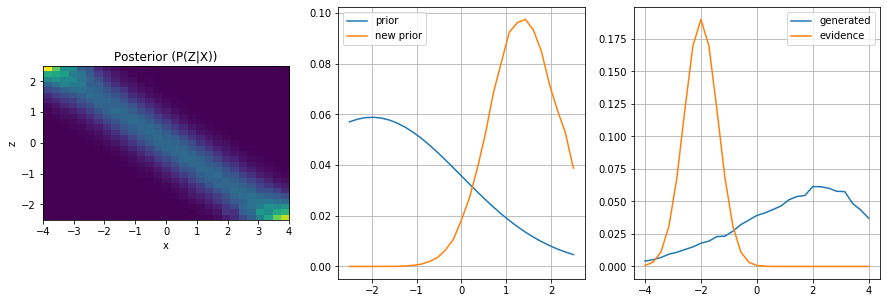

In [9]:
# prior
prior_mu, prior_var = -2, 2
# evidence
evidence_mu, evidence_var = -2, 0.6

def sample_z_from_prior(prior):
    return np.random.choice(range(len(prior)), p=prior)

def generate_datum(idx_z):
    global x_, px_z
    p=Pxz[idx_z,:]/np.sum(Pxz[idx_z,:])
    return np.random.choice(x_, p=p)

prior = stats.norm.pdf(z_, prior_mu, prior_var)/stats.norm.pdf(z_, prior_mu, prior_var).sum().reshape(-1,1)

A = []
for i in range(40000):
    idx_z = sample_z_from_prior(prior.flatten())
    dat = generate_datum(idx_z)
    A.append(dat)
    
generated = np.histogram(A, bins=np.linspace(extent[0], extent[1], Nx+1), density=True)[0]
generated /= generated.sum()

evidence = stats.norm.pdf(x_, evidence_mu, evidence_var)/stats.norm.pdf(x_, evidence_mu, evidence_var).sum().reshape(1,-1)

posterior = px_z*prior/evidence
posterior /= posterior.sum(0, keepdims=True)

joint = posterior * evidence # joint probability P(Z,X) of the posterior and the evidence 
new_prior = joint.sum(axis=1)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('Posterior (P(Z|X))')
plt.imshow(posterior, origin='lower', extent=extent)
plt.ylabel('z')
plt.xlabel('x')

plt.subplot(1,3,2)
plt.plot(z_, prior.flatten(), label='prior')
plt.plot(z_, new_prior, label='new prior')
plt.legend()
plt.grid()


plt.subplot(1,3,3)
plt.plot(x_, generated, label='generated')
plt.plot(x_, evidence.flatten(), label='evidence')
plt.legend()
plt.grid()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


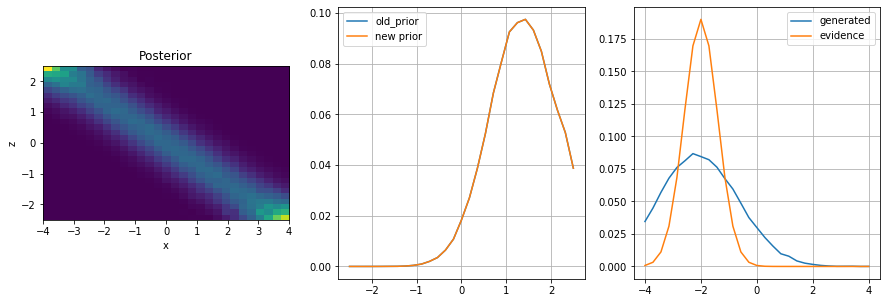

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(z_, new_prior.flatten(), label='old_prior')


prior = new_prior.reshape(1,-1)

A = []
for i in range(40000):
    idx_z = sample_z_from_prior(prior.flatten())
    dat = generate_datum(idx_z)
    A.append(dat)
    
generated = np.histogram(A, bins=np.linspace(extent[0], extent[1], Nx+1), density=True)[0]
generated /= generated.sum()

evidence = stats.norm.pdf(x_, evidence_mu, evidence_var)/stats.norm.pdf(x_, evidence_mu, evidence_var).sum().reshape(1,-1)

posterior = px_z*prior/evidence
posterior /= posterior.sum(0, keepdims=True)

joint = posterior * evidence # joint probability P(Z,X) of the posterior and the evidence 
new_prior = joint.sum(axis=1)



plt.subplot(1,3,1)
plt.title('Posterior')
plt.imshow(posterior, origin='lower', extent=extent)
plt.ylabel('z')
plt.xlabel('x')

plt.subplot(1,3,2)
plt.plot(z_, new_prior, label='new prior')
plt.legend()
plt.grid()


plt.subplot(1,3,3)
plt.plot(x_, generated, label='generated')
plt.plot(x_, evidence.flatten(), label='evidence')
plt.legend()
plt.grid()
